In [1]:
# === 단계 1: 환경 설정 및 라이브러리 임포트 ===

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [2]:
# === 데이터 로드 ===

# 기존 경로 사용
path_to_file = "/home/jovyan/work/AIFFEL_quest_rs/GoingDeeper/Go01/nsmc/ratings.txt"

print("NSMC 데이터 로드 중...")

with open(path_to_file, "r", encoding="utf-8") as f:
    raw = f.read().splitlines()

print(f"전체 데이터 크기: {len(raw)}")
print("\n데이터 구조 확인:")
print(f"헤더: {raw[0]}")
print("\n첫 5개 샘플:")
for i in range(1, 6):
    print(f"{i}: {raw[i]}")

NSMC 데이터 로드 중...
전체 데이터 크기: 200001

데이터 구조 확인:
헤더: id	document	label

첫 5개 샘플:
1: 8112052	어릴때보고 지금다시봐도 재밌어요ㅋㅋ	1
2: 8132799	디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.	1
3: 4655635	폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.	1
4: 9251303	와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지	1
5: 10067386	안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.	1


In [3]:
# === 기본 데이터 검증 ===

print("=== 데이터 품질 확인 ===")

# 데이터 파싱 테스트
valid_count = 0
invalid_count = 0
label_counts = {'0': 0, '1': 0}

for i, line in enumerate(raw[1:], 1):  # 헤더 제외
    try:
        parts = line.split('\t')
        if len(parts) >= 3:
            id_field = parts[0]
            document = parts[1]
            label = parts[2].strip()
            
            if label in ['0', '1'] and document.strip():
                valid_count += 1
                label_counts[label] += 1
            else:
                invalid_count += 1
        else:
            invalid_count += 1
            
        # 진행상황 출력 (10만개마다)
        if i % 100000 == 0:
            print(f"처리 중: {i}개 완료")
            
    except Exception as e:
        invalid_count += 1
        if invalid_count <= 5:  # 처음 몇 개 오류만 출력
            print(f"파싱 오류 (줄 {i}): {e}")

print(f"\n=== 데이터 요약 ===")
print(f"유효한 데이터: {valid_count:,}개")
print(f"무효한 데이터: {invalid_count:,}개")
print(f"부정 리뷰 (0): {label_counts['0']:,}개")
print(f"긍정 리뷰 (1): {label_counts['1']:,}개")
print(f"전체 성공률: {valid_count/(valid_count+invalid_count)*100:.1f}%")

# 샘플 데이터 확인
print(f"\n=== 샘플 데이터 확인 ===")
sample_indices = [1, 50000, 100000, 150000]
for idx in sample_indices:
    if idx < len(raw):
        parts = raw[idx].split('\t')
        if len(parts) >= 3:
            print(f"인덱스 {idx}: 레이블={parts[2]}, 텍스트='{parts[1][:50]}...'")

=== 데이터 품질 확인 ===
처리 중: 100000개 완료
처리 중: 200000개 완료

=== 데이터 요약 ===
유효한 데이터: 199,992개
무효한 데이터: 8개
부정 리뷰 (0): 99,996개
긍정 리뷰 (1): 99,996개
전체 성공률: 100.0%

=== 샘플 데이터 확인 ===
인덱스 1: 레이블=1, 텍스트='어릴때보고 지금다시봐도 재밌어요ㅋㅋ...'
인덱스 50000: 레이블=1, 텍스트='하균신 짱연기 쩔어!!...'
인덱스 100000: 레이블=1, 텍스트='파괴지왕에서 장학우 콘서트 티켓을 얻기위한... ㅋ...'
인덱스 150000: 레이블=0, 텍스트='분위기는 좋았는데, 중반 이후로 지루했다....'


In [4]:
# === 단계 2: 데이터 탐색 및 분석 ===

print("=== 문장 길이 및 품질 분석 ===")

texts = []
labels = []
lengths = []

# 유효한 데이터만 추출
for line in raw[1:]:  # 헤더 제외
    try:
        parts = line.split('\t')
        if len(parts) >= 3:
            text = parts[1].strip()
            label_str = parts[2].strip()
            
            if label_str in ['0', '1'] and text:
                texts.append(text)
                labels.append(int(label_str))
                lengths.append(len(text))
    except:
        continue

print(f"추출된 유효 데이터: {len(texts):,}개")

# 길이 통계
lengths_array = np.array(lengths)
print(f"\n=== 문장 길이 통계 ===")
print(f"최단 길이: {lengths_array.min()}")
print(f"최장 길이: {lengths_array.max()}")
print(f"평균 길이: {lengths_array.mean():.1f}")
print(f"중간값: {np.median(lengths_array):.1f}")
print(f"표준편차: {lengths_array.std():.1f}")

# 백분위수
percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
print(f"\n=== 길이 백분위수 ===")
for p in percentiles:
    value = np.percentile(lengths_array, p)
    print(f"{p}%: {value:.0f}")

=== 문장 길이 및 품질 분석 ===
추출된 유효 데이터: 199,992개

=== 문장 길이 통계 ===
최단 길이: 1
최장 길이: 146
평균 길이: 35.2
중간값: 27.0
표준편차: 29.6

=== 길이 백분위수 ===
5%: 6
10%: 10
25%: 16
50%: 27
75%: 42
90%: 75
95%: 107
99%: 139


/tmp/ipykernel_1560/3162925840.py:32: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1560/3162925840.py:32: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1560/3162925840.py:32: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1560/3162925840.py:32: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1560/3162925840.py:32: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1560/3162925840.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1560/3162925840.py:32: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_la

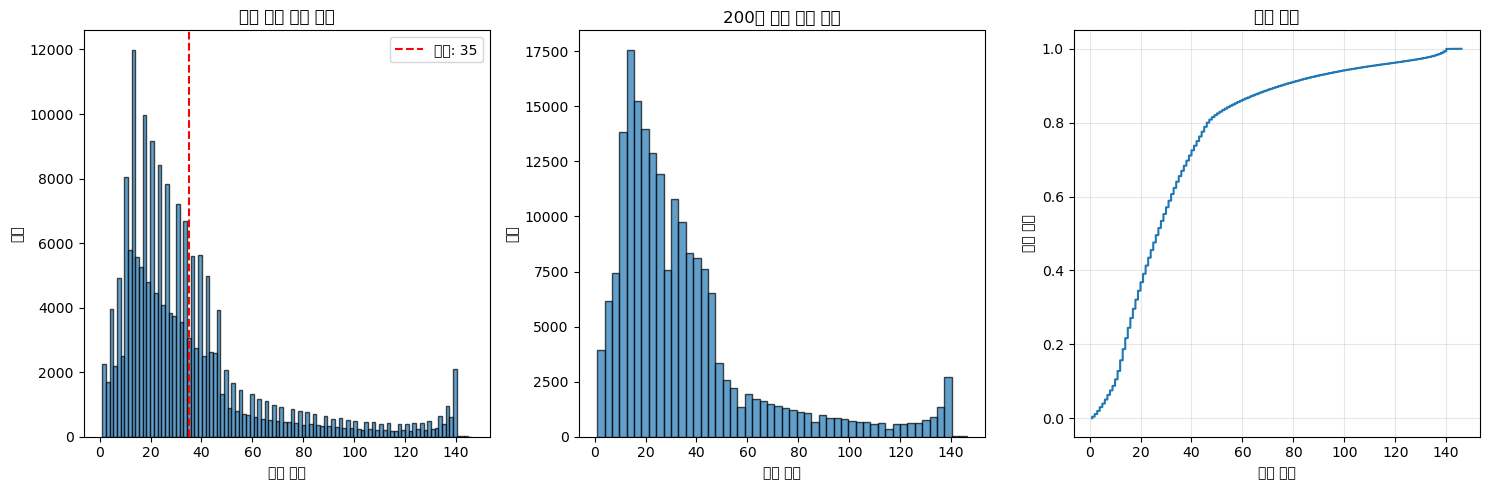


=== 극단적인 길이 샘플 확인 ===
가장 짧은 문장들:
1. 길이 1: '굳'
2. 길이 1: '.'
3. 길이 1: '올'
4. 길이 1: '짱'
5. 길이 1: '♥'

가장 긴 문장들:
1. 길이 144: '"중년부부 사이로 흐르는강 ""바라나시"" 관계와 죽음, 그안에 빠져 흘러가는강. '인간의 위선' 현실이다. 남편의 위선 위에 위선. 쿨한척 뒤엔 아내의 영역 침범 욕구를 보이는 ...'
2. 길이 144: '"보는 내내 짜증나는 영화.주제는 묵직하고 섬세한 표현력이 요구되는데 그저 시종일관 감성팔이. 억지로 슬프라고 강요하는거 같았다. 그와중에 동호가 ""아저씨 살려주세여""라고 외치...'
3. 길이 146: '"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는...'
4. 길이 146: '"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화...'
5. 길이 146: '"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에...'


In [5]:
# === 길이 분포 시각화 ===

plt.figure(figsize=(15, 5))

# 전체 분포
plt.subplot(1, 3, 1)
plt.hist(lengths, bins=100, alpha=0.7, edgecolor='black')
plt.xlabel('문장 길이')
plt.ylabel('빈도')
plt.title('전체 문장 길이 분포')
plt.axvline(np.mean(lengths), color='red', linestyle='--', label=f'평균: {np.mean(lengths):.0f}')
plt.legend()

# 200자 이하만 확대
plt.subplot(1, 3, 2)
lengths_short = [l for l in lengths if l <= 200]
plt.hist(lengths_short, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('문장 길이')
plt.ylabel('빈도')
plt.title('200자 이하 문장 분포')

# 누적 분포
plt.subplot(1, 3, 3)
sorted_lengths = np.sort(lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
plt.plot(sorted_lengths, cumulative)
plt.xlabel('문장 길이')
plt.ylabel('누적 비율')
plt.title('누적 분포')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 극단적인 길이의 샘플들 확인
print("\n=== 극단적인 길이 샘플 확인 ===")
print("가장 짧은 문장들:")
short_indices = np.argsort(lengths)[:5]
for i, idx in enumerate(short_indices):
    print(f"{i+1}. 길이 {lengths[idx]}: '{texts[idx]}'")

print("\n가장 긴 문장들:")
long_indices = np.argsort(lengths)[-5:]
for i, idx in enumerate(long_indices):
    print(f"{i+1}. 길이 {lengths[idx]}: '{texts[idx][:100]}...'")

In [6]:
# === 중복 제거 및 품질 필터링 ===

print("=== 데이터 정제 시작 ===")
original_count = len(texts)

# 1. 중복 제거 (텍스트 기준)
print("1. 중복 문장 제거 중...")
seen_texts = set()
unique_texts = []
unique_labels = []

for text, label in zip(texts, labels):
    if text not in seen_texts:
        seen_texts.add(text)
        unique_texts.append(text)
        unique_labels.append(label)

duplicate_count = original_count - len(unique_texts)
print(f"   중복 제거: {duplicate_count:,}개 ({duplicate_count/original_count*100:.1f}%)")

# 2. 길이 기준 필터링 (10자 이상 200자 이하)
print("2. 길이 기준 필터링 중...")
MIN_LENGTH = 10
MAX_LENGTH = 200

filtered_texts = []
filtered_labels = []

for text, label in zip(unique_texts, unique_labels):
    if MIN_LENGTH <= len(text) <= MAX_LENGTH:
        filtered_texts.append(text)
        filtered_labels.append(label)

length_filtered = len(unique_texts) - len(filtered_texts)
print(f"   길이 필터링 제거: {length_filtered:,}개")
print(f"   (10자 미만 또는 200자 초과)")

# 3. 내용 품질 필터링
print("3. 내용 품질 필터링 중...")
quality_texts = []
quality_labels = []

for text, label in zip(filtered_texts, filtered_labels):
    # 의미있는 한글이 포함되어야 함
    korean_chars = len(re.findall(r'[가-힣]', text))
    if korean_chars >= 3:  # 최소 한글 3자 이상
        # 특수문자만으로 이루어진 문장 제외
        clean_text = re.sub(r'[^\w\s가-힣]', '', text)
        if len(clean_text.strip()) >= 5:
            quality_texts.append(text)
            quality_labels.append(label)

quality_filtered = len(filtered_texts) - len(quality_texts)
print(f"   품질 필터링 제거: {quality_filtered:,}개")

# 최종 결과
final_count = len(quality_texts)
total_removed = original_count - final_count
print(f"\n=== 정제 결과 ===")
print(f"원본 데이터: {original_count:,}개")
print(f"최종 데이터: {final_count:,}개")
print(f"제거된 데이터: {total_removed:,}개 ({total_removed/original_count*100:.1f}%)")

# 레이블 분포 확인
label_counts = Counter(quality_labels)
print(f"\n최종 레이블 분포:")
print(f"부정 (0): {label_counts[0]:,}개 ({label_counts[0]/final_count*100:.1f}%)")
print(f"긍정 (1): {label_counts[1]:,}개 ({label_counts[1]/final_count*100:.1f}%)")

# 정제된 데이터를 전역 변수로 저장
cleaned_texts = quality_texts
cleaned_labels = quality_labels

=== 데이터 정제 시작 ===
1. 중복 문장 제거 중...
   중복 제거: 5,449개 (2.7%)
2. 길이 기준 필터링 중...
   길이 필터링 제거: 12,845개
   (10자 미만 또는 200자 초과)
3. 내용 품질 필터링 중...
   품질 필터링 제거: 1,285개

=== 정제 결과 ===
원본 데이터: 199,992개
최종 데이터: 180,413개
제거된 데이터: 19,579개 (9.8%)

최종 레이블 분포:
부정 (0): 90,328개 (50.1%)
긍정 (1): 90,085개 (49.9%)


In [7]:
# 새로운 길이 분포
new_lengths = [len(text) for text in cleaned_texts]
new_lengths_array = np.array(new_lengths)

print(f"정제 후 길이 통계:")
print(f"최단: {new_lengths_array.min()}, 최장: {new_lengths_array.max()}")
print(f"평균: {new_lengths_array.mean():.1f}, 중간값: {np.median(new_lengths_array):.1f}")

# 샘플 확인
print(f"\n=== 정제된 데이터 샘플 ===")
sample_indices = np.random.choice(len(cleaned_texts), 10, replace=False)
for i, idx in enumerate(sample_indices):
    label_name = "긍정" if cleaned_labels[idx] == 1 else "부정"
    print(f"{i+1}. [{label_name}] {cleaned_texts[idx]}")

정제 후 길이 통계:
최단: 10, 최장: 146
평균: 38.3, 중간값: 29.0

=== 정제된 데이터 샘플 ===
1. [긍정] 50부 너무 짧다 ㅜㅜ더 했으믄 싶다 정말 최고의 드라마였다
2. [부정] 돈주고보면 돈이아깝고 공짜로보면 시간이아까운듯
3. [긍정] 가슴벅찬 감동의 역사와 음악....하지만 사실과 음악을 모르는 이에게는? ...다큐잖아!!! 좋아!!!
4. [부정] 기법8점 스토리-7점이라고 감히말함다. 절친이몇년간사랑했던여자와 다알면서결혼을?
5. [긍정] 몇 번 봤는데도 재밌음!
6. [긍정] 레이의 집념과 바람을 이어 받은 바이올린으로 다른 생각과 삶에 찌들어 있던 단원들을 하나로 만들어 염원하던 완벽한 하모니를 이끌어내 모두를 감동시키는 영화였다. 음악을 연주하는 무대는 영혼으로 연결되어있다는 것을 다시금 일깨워 주는 시간이었다.
7. [긍정] 지금의 핀처를 만들게 해준 역작..
8. [긍정] 크리스탈이랑 비 연기호흡 좋았고, 재미있게 잘봤어요~ 벌써 마지막회라서 너무 아쉬습니다ㅠ 정말 재미있었습니다^^
9. [긍정] 촬영지가 어디죠 ? 공원같은곳이요 종소리달려있고 어디인가요 ?
10. [부정] 역사이나.. 알차지 못하네용


In [8]:
# === 단계 3: SentencePiece 토크나이저 클래스 구현 ===

import sentencepiece as spm
import os
import re

class NSMCSentencePieceTokenizer:
    def __init__(self, vocab_size=8000, model_type='bpe', model_prefix='nsmc_sp'):
        """
        NSMC 데이터를 위한 SentencePiece 토크나이저
        
        Args:
            vocab_size: 어휘 크기 (기본값: 8000)
            model_type: 'bpe' 또는 'unigram' (기본값: 'bpe')
            model_prefix: 모델 파일 접두사 (기본값: 'nsmc_sp')
        """
        self.vocab_size = vocab_size
        self.model_type = model_type
        self.model_prefix = model_prefix
        self.model_path = f"{model_prefix}.model"
        self.vocab_path = f"{model_prefix}.vocab"
        self.sp = None
        
        print(f"SentencePiece 토크나이저 초기화")
        print(f"- 어휘 크기: {vocab_size}")
        print(f"- 모델 타입: {model_type}")
        print(f"- 모델 파일: {self.model_path}")
        
    def preprocess_text(self, text):
        """
        한국어 영화 리뷰에 특화된 텍스트 전처리
        """
        if not text or not isinstance(text, str):
            return ""
        
        # 기본 정리
        text = text.strip()
        
        # 반복되는 특수 문자 정규화
        text = re.sub(r'[ㅋㅋ]+', ' ㅋㅋ ', text)  # 웃음 표현
        text = re.sub(r'[ㅠㅜ]+', ' ㅠㅠ ', text)  # 울음 표현  
        text = re.sub(r'!{2,}', '!', text)        # 반복 느낌표
        text = re.sub(r'\?{2,}', '?', text)       # 반복 물음표
        text = re.sub(r'\.{3,}', '...', text)     # 반복 점
        
        # 이모티콘 및 특수문자 처리
        text = re.sub(r'[^\w\s가-힣ㅋㅠㅜ.,!?~\-]', ' ', text)
        
        # 연속된 공백 제거
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()
    
    def prepare_corpus_for_training(self, texts):
        """
        SentencePiece 학습을 위한 코퍼스 준비
        
        Args:
            texts: 텍스트 리스트
            
        Returns:
            processed_texts: 전처리된 텍스트 리스트
        """
        print("코퍼스 전처리 중...")
        
        processed_texts = []
        skipped_count = 0
        
        for i, text in enumerate(texts):
            processed_text = self.preprocess_text(text)
            
            # 전처리 후에도 의미있는 내용이 남아있는지 확인
            if processed_text and len(processed_text) >= 5:
                processed_texts.append(processed_text)
            else:
                skipped_count += 1
            
            # 진행상황 출력
            if (i + 1) % 50000 == 0:
                print(f"  {i + 1:,}개 처리 완료")
        
        print(f"전처리 완료:")
        print(f"- 처리된 텍스트: {len(processed_texts):,}개")
        print(f"- 건너뛴 텍스트: {skipped_count:,}개")
        
        return processed_texts
    
    def train_sentencepiece(self, texts, sample_size=None):
        """
        SentencePiece 모델 학습
        
        Args:
            texts: 학습용 텍스트 리스트
            sample_size: 샘플링할 텍스트 수 (None이면 전체 사용)
        """
        # 샘플링 (메모리 및 시간 절약)
        if sample_size and len(texts) > sample_size:
            import random
            random.seed(42)
            texts = random.sample(texts, sample_size)
            print(f"학습용 데이터 샘플링: {sample_size:,}개")
        
        print(f"SentencePiece 모델 학습 시작")
        print(f"- 학습 데이터: {len(texts):,}개")
        print(f"- 어휘 크기: {self.vocab_size}")
        
        # 학습용 임시 파일 생성
        train_file = f"{self.model_prefix}_train.txt"
        
        with open(train_file, 'w', encoding='utf-8') as f:
            for text in texts:
                f.write(text + '\n')
        
        # SentencePiece 모델 학습
        try:
            spm.SentencePieceTrainer.train(
                input=train_file,
                model_prefix=self.model_prefix,
                vocab_size=self.vocab_size,
                model_type=self.model_type,
                character_coverage=0.9995,  # 한국어에 적합한 설정
                pad_id=0,     # <pad> 토큰
                unk_id=1,     # <unk> 토큰  
                bos_id=2,     # <s> 토큰
                eos_id=3,     # </s> 토큰
                user_defined_symbols=['<mask>'],  # 추가 특수 토큰
                max_sentence_length=512,
                shuffle_input_sentence=True,
                split_by_whitespace=True,
            )
            
            print(f"SentencePiece 모델 학습 완료!")
            print(f"- 모델 파일: {self.model_path}")
            print(f"- 어휘 파일: {self.vocab_path}")
            
        except Exception as e:
            print(f"모델 학습 중 오류 발생: {e}")
            raise
        
        finally:
            # 임시 파일 정리
            if os.path.exists(train_file):
                os.remove(train_file)
        
    def load_model(self):
        """
        학습된 SentencePiece 모델 로드
        """
        if not os.path.exists(self.model_path):
            raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {self.model_path}")
        
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(self.model_path)
        
        print(f"SentencePiece 모델 로드 완료")
        print(f"- 실제 어휘 크기: {self.sp.vocab_size()}")
        
        # 특수 토큰 확인
        special_tokens = {
            'pad': self.sp.id_to_piece(0),
            'unk': self.sp.id_to_piece(1), 
            'bos': self.sp.id_to_piece(2),
            'eos': self.sp.id_to_piece(3)
        }
        print(f"- 특수 토큰: {special_tokens}")
    
    def encode(self, texts, add_bos=True, add_eos=True):
        """
        텍스트를 토큰 ID로 인코딩
        
        Args:
            texts: 인코딩할 텍스트 (문자열 또는 리스트)
            add_bos: BOS 토큰 추가 여부
            add_eos: EOS 토큰 추가 여부
            
        Returns:
            sequences: 토큰 ID 시퀀스 리스트 (torch.Tensor)
        """
        if self.sp is None:
            self.load_model()
        
        if isinstance(texts, str):
            texts = [texts]
        
        sequences = []
        for text in texts:
            processed_text = self.preprocess_text(text)
            if processed_text:
                ids = self.sp.encode(processed_text, add_bos=add_bos, add_eos=add_eos)
                sequences.append(torch.tensor(ids, dtype=torch.long))
            else:
                # 빈 텍스트인 경우 UNK 토큰만
                ids = [1]  # UNK token
                if add_bos:
                    ids = [2] + ids  # BOS + UNK
                if add_eos:
                    ids = ids + [3]  # + EOS
                sequences.append(torch.tensor(ids, dtype=torch.long))
        
        return sequences
    
    def decode(self, sequences):
        """
        토큰 ID를 텍스트로 디코딩
        
        Args:
            sequences: 토큰 ID 시퀀스 리스트
            
        Returns:
            texts: 디코딩된 텍스트 리스트
        """
        if self.sp is None:
            self.load_model()
        
        texts = []
        for seq in sequences:
            if isinstance(seq, torch.Tensor):
                seq = seq.tolist()
            
            # 패딩 토큰(0) 제거
            seq = [id for id in seq if id != 0]
            
            if seq:
                text = self.sp.decode(seq)
                texts.append(text)
            else:
                texts.append("")
        
        return texts
    
    def encode_as_pieces(self, texts):
        """
        텍스트를 서브워드 조각으로 인코딩
        
        Args:
            texts: 인코딩할 텍스트 (문자열 또는 리스트)
            
        Returns:
            pieces_list: 서브워드 조각 리스트
        """
        if self.sp is None:
            self.load_model()
        
        if isinstance(texts, str):
            texts = [texts]
        
        pieces_list = []
        for text in texts:
            processed_text = self.preprocess_text(text)
            if processed_text:
                pieces = self.sp.encode_as_pieces(processed_text)
                pieces_list.append(pieces)
            else:
                pieces_list.append(['<unk>'])
        
        return pieces_list
    
    def get_vocab_size(self):
        """어휘 크기 반환"""
        if self.sp is None:
            self.load_model()
        return self.sp.vocab_size()
    
    def get_pad_id(self):
        """패딩 토큰 ID 반환"""
        return 0
    
    def get_special_tokens_dict(self):
        """특수 토큰 딕셔너리 반환"""
        return {
            'pad_token': '<pad>',
            'unk_token': '<unk>',
            'bos_token': '<s>',
            'eos_token': '</s>',
            'pad_token_id': 0,
            'unk_token_id': 1,
            'bos_token_id': 2,
            'eos_token_id': 3,
        }

In [9]:
# === 토크나이저 인스턴스 생성 ===

print("=== NSMC SentencePiece 토크나이저 생성 ===")

# 토크나이저 생성 (어휘 크기 16000으로 시작)
tokenizer = NSMCSentencePieceTokenizer(vocab_size=10000,model_type='bpe',model_prefix='nsmc_sp')

=== NSMC SentencePiece 토크나이저 생성 ===
SentencePiece 토크나이저 초기화
- 어휘 크기: 10000
- 모델 타입: bpe
- 모델 파일: nsmc_sp.model


In [10]:
print("=== SentencePiece 토크나이저 학습 시작 ===")

# 학습용 코퍼스 준비
print("1. 학습용 코퍼스 준비 중...")
training_corpus = tokenizer.prepare_corpus_for_training(cleaned_texts)

# 메모리 절약을 위해 샘플링 (전체 데이터가 많은 경우)
sample_size = min(50000, len(training_corpus))
print(f"2. 학습 데이터 크기 조정: {len(training_corpus):,} -> {sample_size:,}")

# SentencePiece 모델 학습
print("3. SentencePiece 모델 학습 중... (약 2-3분 소요)")
tokenizer.train_sentencepiece(training_corpus, sample_size=sample_size)

# 학습된 모델 로드
print("4. 학습된 모델 로드 중...")
tokenizer.load_model()

print("토크나이저 학습 및 로드 완료!")

=== SentencePiece 토크나이저 학습 시작 ===
1. 학습용 코퍼스 준비 중...
코퍼스 전처리 중...
  50,000개 처리 완료
  100,000개 처리 완료
  150,000개 처리 완료
전처리 완료:
- 처리된 텍스트: 180,413개
- 건너뛴 텍스트: 0개
2. 학습 데이터 크기 조정: 180,413 -> 50,000
3. SentencePiece 모델 학습 중... (약 2-3분 소요)
학습용 데이터 샘플링: 50,000개
SentencePiece 모델 학습 시작
- 학습 데이터: 50,000개
- 어휘 크기: 10000
SentencePiece 모델 학습 완료!
- 모델 파일: nsmc_sp.model
- 어휘 파일: nsmc_sp.vocab
4. 학습된 모델 로드 중...
SentencePiece 모델 로드 완료
- 실제 어휘 크기: 10000
- 특수 토큰: {'pad': '<pad>', 'unk': '<unk>', 'bos': '<s>', 'eos': '</s>'}
토크나이저 학습 및 로드 완료!


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: nsmc_sp_train.txt
  input_format: 
  model_prefix: nsmc_sp
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 512
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <mask>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_d

In [11]:
# === 토크나이저 기본 성능 테스트 ===

print("=== 토크나이징 성능 테스트 ===")

# 테스트용 샘플 문장들 (다양한 특성)
test_sentences = [
    "이 영화 정말 재밌어요!",
    "배우들의 연기가 너무 좋았습니다.",
    "스토리가 지루하고 예측 가능해요 ㅠㅠ",
    "오랜만에 본 감동적인 한국 영화네요 ㅋㅋㅋ",
    "돈이 아까운 영화였습니다... 실망",
    "최고의 영화!!!! 다시 보고 싶어요",
    "액션 장면이 화려하고 스릴감 넘쳐요",
    "로맨스 영화인데 감동이 없네요",
    "코미디 요소가 적절히 섞여있어서 재밌었어요"
]

print("서브워드 토크나이징 결과:")
print("=" * 80)

for i, sentence in enumerate(test_sentences, 1):
    # 서브워드로 분할
    pieces = tokenizer.encode_as_pieces(sentence)
    
    # ID로 인코딩
    ids = tokenizer.encode(sentence, add_bos=True, add_eos=True)
    
    # 다시 디코딩
    decoded = tokenizer.decode(ids)
    
    print(f"{i}. 원문: {sentence}")
    print(f"   토큰: {pieces[0]}")
    print(f"   개수: {len(pieces[0])}개")
    print(f"   ID: {ids[0].tolist()}")
    print(f"   복원: {decoded[0]}")
    print("-" * 80)

=== 토크나이징 성능 테스트 ===
서브워드 토크나이징 결과:
1. 원문: 이 영화 정말 재밌어요!
   토큰: ['▁이', '▁영화', '▁정말', '▁재밌어요', '!']
   개수: 5개
   ID: [2, 8, 7, 44, 913, 8457, 3]
   복원: 이 영화 정말 재밌어요!
--------------------------------------------------------------------------------
2. 원문: 배우들의 연기가 너무 좋았습니다.
   토큰: ['▁배우들의', '▁연기가', '▁너무', '▁좋았습니다', '.']
   개수: 5개
   ID: [2, 868, 690, 27, 2132, 8395, 3]
   복원: 배우들의 연기가 너무 좋았습니다.
--------------------------------------------------------------------------------
3. 원문: 스토리가 지루하고 예측 가능해요 ㅠㅠ
   토큰: ['▁스토리가', '▁지루하고', '▁예측', '▁가능', '해요', '▁ᅲᅲ']
   개수: 6개
   ID: [2, 840, 909, 5576, 1828, 719, 67, 3]
   복원: 스토리가 지루하고 예측 가능해요 ᅲᅲ
--------------------------------------------------------------------------------
4. 원문: 오랜만에 본 감동적인 한국 영화네요 ㅋㅋㅋ
   토큰: ['▁오랜만에', '▁본', '▁감동적인', '▁한국', '▁영화네요', '▁ᄏᄏ']
   개수: 6개
   ID: [2, 934, 96, 1375, 236, 1147, 23, 3]
   복원: 오랜만에 본 감동적인 한국 영화네요 ᄏᄏ
--------------------------------------------------------------------------------
5. 원문: 돈이 아까운 영화였습니다... 실망
 

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class NSMCDataset(Dataset):
    """
    NSMC 감성분석을 위한 PyTorch Dataset 클래스
    SentencePiece 토크나이저와 연동
    """
    
    def __init__(self, texts, labels, tokenizer, max_length=128, add_special_tokens=True):
        """
        Args:
            texts: 텍스트 리스트
            labels: 레이블 리스트 (0: 부정, 1: 긍정)
            tokenizer: SentencePiece 토크나이저
            max_length: 최대 시퀀스 길이
            add_special_tokens: BOS/EOS 토큰 추가 여부
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.add_special_tokens = add_special_tokens
        
        print(f"NSMCDataset 초기화:")
        print(f"- 데이터 수: {len(texts)}")
        print(f"- 최대 길이: {max_length}")
        print(f"- 특수 토큰 추가: {add_special_tokens}")
        
        # 레이블 분포 확인
        label_counts = Counter(labels)
        print(f"- 레이블 분포: 부정({label_counts[0]}) / 긍정({label_counts[1]})")
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
        개별 아이템 반환
        
        Returns:
            dict: {
                'input_ids': 토큰 ID 텐서,
                'attention_mask': 어텐션 마스크,
                'labels': 레이블 텐서
            }
        """
        text = self.texts[idx]
        label = self.labels[idx]
        
        # 텍스트를 토큰 ID로 변환
        encoded = self.tokenizer.encode(
            text, 
            add_bos=self.add_special_tokens, 
            add_eos=self.add_special_tokens
        )
        tokens = encoded[0]  # 첫 번째 (유일한) 시퀀스
        
        # 길이 조정
        if len(tokens) > self.max_length:
            # 너무 긴 경우 자르기
            tokens = tokens[:self.max_length]
        else:
            # 짧은 경우 패딩 추가
            pad_length = self.max_length - len(tokens)
            padding = torch.full(
                (pad_length,), 
                self.tokenizer.get_pad_id(), 
                dtype=torch.long
            )
            tokens = torch.cat([tokens, padding])
        
        # 어텐션 마스크 생성 (실제 토큰은 1, 패딩은 0)
        attention_mask = (tokens != self.tokenizer.get_pad_id()).float()
        
        return {
            'input_ids': tokens,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }
    
    def get_sample_batch(self, batch_size=4):
        """
        샘플 배치 반환 (테스트용)
        """
        indices = np.random.choice(len(self), batch_size, replace=False)
        batch = [self[i] for i in indices]
        
        # 배치 구성
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask, 
            'labels': labels,
            'original_texts': [self.texts[i] for i in indices]
        }

In [14]:
# === 데이터셋 클래스 동작 테스트 ===

print("=== 데이터셋 동작 테스트 ===")

# 작은 샘플로 테스트 데이터셋 생성
test_texts = cleaned_texts[:1000]  # 처음 1000개
test_labels = cleaned_labels[:1000]

# 테스트 데이터셋 생성
test_dataset = NSMCDataset(
    texts=test_texts,
    labels=test_labels,
    tokenizer=tokenizer,
    max_length=128,
    add_special_tokens=True
)

print(f"\n데이터셋 크기: {len(test_dataset)}")

# 개별 아이템 테스트
print("\n=== 개별 아이템 확인 ===")
sample_item = test_dataset[0]

print(f"첫 번째 아이템:")
print(f"- 원본 텍스트: '{test_texts[0]}'")
print(f"- 레이블: {test_labels[0]} ({'긍정' if test_labels[0] == 1 else '부정'})")
print(f"- input_ids 크기: {sample_item['input_ids'].shape}")
print(f"- attention_mask 크기: {sample_item['attention_mask'].shape}")
print(f"- 실제 토큰 수: {sample_item['attention_mask'].sum().item()}")
print(f"- input_ids: {sample_item['input_ids'][:20].tolist()}...")  # 처음 20개만

# 복원 테스트
decoded_text = tokenizer.decode([sample_item['input_ids']])[0]
print(f"- 복원된 텍스트: '{decoded_text}'")


=== 데이터셋 동작 테스트 ===
NSMCDataset 초기화:
- 데이터 수: 1000
- 최대 길이: 128
- 특수 토큰 추가: True
- 레이블 분포: 부정(0) / 긍정(1000)

데이터셋 크기: 1000

=== 개별 아이템 확인 ===
첫 번째 아이템:
- 원본 텍스트: '어릴때보고 지금다시봐도 재밌어요ㅋㅋ'
- 레이블: 1 (긍정)
- input_ids 크기: torch.Size([128])
- attention_mask 크기: torch.Size([128])
- 실제 토큰 수: 9.0
- input_ids: [2, 1766, 160, 225, 1451, 435, 913, 23, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
- 복원된 텍스트: '어릴때보고 지금다시봐도 재밌어요 ᄏᄏ'


In [15]:
# === 배치 처리 및 DataLoader 테스트 ===

print("=== 배치 처리 테스트 ===")

# DataLoader 생성
test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=True,
    num_workers=0  # Windows 호환성
)

print(f"DataLoader 생성 완료:")
print(f"- 배치 크기: 8")
print(f"- 총 배치 수: {len(test_loader)}")

# 첫 번째 배치 확인
first_batch = next(iter(test_loader))

print(f"\n첫 번째 배치 구조:")
for key, value in first_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"- {key}: {value.shape} {value.dtype}")
    else:
        print(f"- {key}: {type(value)} (길이: {len(value)})")

# 배치 내용 확인
print(f"\n배치 내용 샘플:")
for i in range(3):  # 처음 3개만
    orig_text = test_texts[test_loader.dataset.texts.index(test_texts[i])] if i < len(test_texts) else "N/A"
    label = first_batch['labels'][i].item()
    mask_sum = first_batch['attention_mask'][i].sum().item()
    
    print(f"{i+1}. 레이블: {label}, 실제 토큰 수: {mask_sum}")
    print(f"   원문: '{test_texts[i][:50]}...'")

# 메모리 효율성 확인
sample_batch = test_dataset.get_sample_batch(batch_size=4)
print(f"\n샘플 배치 테스트:")
print(f"- input_ids: {sample_batch['input_ids'].shape}")
print(f"- 메모리 사용량: {sample_batch['input_ids'].nelement() * sample_batch['input_ids'].element_size() / 1024:.1f} KB")

=== 배치 처리 테스트 ===
DataLoader 생성 완료:
- 배치 크기: 8
- 총 배치 수: 125

첫 번째 배치 구조:
- input_ids: torch.Size([8, 128]) torch.int64
- attention_mask: torch.Size([8, 128]) torch.float32
- labels: torch.Size([8]) torch.int64

배치 내용 샘플:
1. 레이블: 1, 실제 토큰 수: 9.0
   원문: '어릴때보고 지금다시봐도 재밌어요ㅋㅋ...'
2. 레이블: 1, 실제 토큰 수: 68.0
   원문: '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부...'
3. 레이블: 1, 실제 토큰 수: 15.0
   원문: '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고....'

샘플 배치 테스트:
- input_ids: torch.Size([4, 128])
- 메모리 사용량: 4.0 KB


In [17]:
class NSMCDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoded = self.tokenizer.encode(text, add_bos=True, add_eos=True)
        tokens = encoded[0]
        
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        else:
            padding = torch.full((self.max_length - len(tokens),), 
                               self.tokenizer.get_pad_id(), dtype=torch.long)
            tokens = torch.cat([tokens, padding])
        
        attention_mask = (tokens != self.tokenizer.get_pad_id()).float()
        
        return {
            'input_ids': tokens,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_classes=2, dropout=0.3):
        super(SentimentClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, 
                           batch_first=True, bidirectional=True, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)
        embedded = self.dropout(embedded)
        
        lstm_output, (hidden, cell) = self.lstm(embedded)
        
        if attention_mask is not None:
            batch_size = lstm_output.size(0)
            seq_lengths = attention_mask.sum(dim=1).long() - 1
            last_outputs = []
            for i in range(batch_size):
                last_outputs.append(lstm_output[i, seq_lengths[i], :])
            features = torch.stack(last_outputs)
        else:
            features = lstm_output[:, -1, :]
        
        logits = self.classifier(features)
        return logits

In [19]:
import random

def prepare_balanced_data(raw_data, max_samples=50000):
    """균형잡힌 데이터 준비"""
    
    # 전체 데이터에서 텍스트와 레이블 추출
    all_texts = []
    all_labels = []
    
    print("전체 데이터 파싱 중...")
    for line in raw_data[1:]:  # 헤더 제외
        parts = line.split('\t')
        if len(parts) >= 3:
            text = parts[1].strip()
            label_str = parts[2].strip()
            
            if label_str in ['0', '1'] and text and len(text) > 10:
                all_texts.append(text)
                all_labels.append(int(label_str))
    
    print(f"전체 파싱된 데이터: {len(all_texts)}개")
    
    # 긍정/부정 분리
    positive_data = [(text, label) for text, label in zip(all_texts, all_labels) if label == 1]
    negative_data = [(text, label) for text, label in zip(all_texts, all_labels) if label == 0]
    
    print(f"긍정 데이터: {len(positive_data)}개")
    print(f"부정 데이터: {len(negative_data)}개")
    
    # 균형잡힌 샘플링
    samples_per_class = min(max_samples // 2, len(positive_data), len(negative_data))
    
    # 랜덤 샘플링
    random.seed(42)
    selected_positive = random.sample(positive_data, samples_per_class)
    selected_negative = random.sample(negative_data, samples_per_class)
    
    # 결합 및 셔플
    combined_data = selected_positive + selected_negative
    random.shuffle(combined_data)
    
    # 텍스트와 레이블 분리
    final_texts = [item[0] for item in combined_data]
    final_labels = [item[1] for item in combined_data]
    
    return final_texts, final_labels

# 균형잡힌 데이터 준비
print("=== 균형잡힌 데이터 준비 ===")
texts, labels = prepare_balanced_data(raw, max_samples=50000)

print(f"\n최종 결과:")
print(f"- 총 데이터 수: {len(texts)}")
print(f"- 긍정 샘플 (1): {sum(labels)}")
print(f"- 부정 샘플 (0): {len(labels) - sum(labels)}")
print(f"- 긍정 비율: {sum(labels)/len(labels):.2%}")

# 샘플 확인
print(f"\n샘플 확인:")
for i in range(5):
    print(f"샘플 {i+1}: 레이블={labels[i]}, 텍스트='{texts[i][:50]}...'")

=== 균형잡힌 데이터 준비 ===
전체 데이터 파싱 중...
전체 파싱된 데이터: 178979개
긍정 데이터: 89334개
부정 데이터: 89645개

최종 결과:
- 총 데이터 수: 50000
- 긍정 샘플 (1): 25000
- 부정 샘플 (0): 25000
- 긍정 비율: 50.00%

샘플 확인:
샘플 1: 레이블=0, 텍스트='이 영화가 흥행한뒤로 남은게 뭐가있는가??...'
샘플 2: 레이블=1, 텍스트='비디오드롬 이후의 또 하나의 오묘한 영화...'
샘플 3: 레이블=1, 텍스트='채널CGV에서 이 영화봤는데..와..고등학교때 짝사랑했던 친구가 생각나던..막 설레이네.....'
샘플 4: 레이블=1, 텍스트='원작의 갈등과 감동을 잘 뽑아낸 좋은작품. 여자라면 공감90%이상...'
샘플 5: 레이블=1, 텍스트='오랜만이다. 정말 3편까진 그나마 참아줬지만 이미 4편부턴 '무서운 영화' 수준...'


In [20]:
from sklearn.model_selection import train_test_split

print("=== 데이터셋 및 데이터로더 생성 ===")

# 이미 준비된 texts, labels 사용 (데이터 추출 부분 제거)
print(f"사용할 데이터: {len(texts)}개")
print(f"긍정: {sum(labels)}개, 부정: {len(labels) - sum(labels)}개")

# 훈련/검증 분할
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"훈련 데이터: {len(train_texts)}개")
print(f"검증 데이터: {len(val_texts)}개")

# 데이터셋 생성
train_dataset = NSMCDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = NSMCDataset(val_texts, val_labels, tokenizer, max_length=128)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

=== 데이터셋 및 데이터로더 생성 ===
사용할 데이터: 50000개
긍정: 25000개, 부정: 25000개
훈련 데이터: 40000개
검증 데이터: 10000개


In [21]:
# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

model = SentimentClassifier(
    vocab_size=tokenizer.get_vocab_size(),
    embedding_dim=256,
    hidden_dim=512,
    num_classes=2,
    dropout=0.2
).to(device)

print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

# 옵티마이저와 손실함수
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

# 훈련 루프 (tqdm 제거한 버전)
epochs = 10
print(f"\n=== 모델 훈련 시작 (총 {epochs} 에포크) ===")

for epoch in range(epochs):
    model.train()
    train_losses = []
    train_preds = []
    train_true = []
    
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # 훈련 (진행상황 표시 개선)
    total_batches = len(train_loader)
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_true.extend(labels.cpu().numpy())
        
        # 진행상황 출력 (10% 단위)
        if (batch_idx + 1) % (total_batches // 10) == 0 or batch_idx == total_batches - 1:
            progress = (batch_idx + 1) / total_batches * 100
            print(f"  훈련 진행: {progress:.0f}% ({batch_idx+1}/{total_batches})")
    
    # 검증
    model.eval()
    val_losses = []
    val_preds = []
    val_true = []
    
    print("  검증 중...")
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            val_losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
    
    # 결과 출력
    train_acc = accuracy_score(train_true, train_preds)
    val_acc = accuracy_score(val_true, val_preds)
    
    print(f"  Train Loss: {np.mean(train_losses):.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {np.mean(val_losses):.4f}, Val Acc: {val_acc:.4f}")
    
    # 최고 성능 모델 저장
    if epoch == 0 or val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"  ✓ 새로운 최고 성능! 모델 저장 (정확도: {val_acc:.4f})")

print(f"\n훈련 완료! 최고 검증 정확도: {best_val_acc:.4f}")

사용 디바이스: cuda


/opt/conda/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


모델 파라미터 수: 6,239,746

=== 모델 훈련 시작 (총 10 에포크) ===

Epoch 1/10
  훈련 진행: 10% (125/1250)
  훈련 진행: 20% (250/1250)
  훈련 진행: 30% (375/1250)
  훈련 진행: 40% (500/1250)
  훈련 진행: 50% (625/1250)
  훈련 진행: 60% (750/1250)
  훈련 진행: 70% (875/1250)
  훈련 진행: 80% (1000/1250)
  훈련 진행: 90% (1125/1250)
  훈련 진행: 100% (1250/1250)
  검증 중...
  Train Loss: 0.5793, Train Acc: 0.6948
  Val Loss: 0.4895, Val Acc: 0.7713
  ✓ 새로운 최고 성능! 모델 저장 (정확도: 0.7713)

Epoch 2/10
  훈련 진행: 10% (125/1250)
  훈련 진행: 20% (250/1250)
  훈련 진행: 30% (375/1250)
  훈련 진행: 40% (500/1250)
  훈련 진행: 50% (625/1250)
  훈련 진행: 60% (750/1250)
  훈련 진행: 70% (875/1250)
  훈련 진행: 80% (1000/1250)
  훈련 진행: 90% (1125/1250)
  훈련 진행: 100% (1250/1250)
  검증 중...
  Train Loss: 0.4306, Train Acc: 0.8040
  Val Loss: 0.4262, Val Acc: 0.8144
  ✓ 새로운 최고 성능! 모델 저장 (정확도: 0.8144)

Epoch 3/10
  훈련 진행: 10% (125/1250)
  훈련 진행: 20% (250/1250)
  훈련 진행: 30% (375/1250)
  훈련 진행: 40% (500/1250)
  훈련 진행: 50% (625/1250)
  훈련 진행: 60% (750/1250)
  훈련 진행: 70% (875/1250)
  훈련 진행: 80% (10